In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#**Warning:** 
Changing factory_reset to True will remove all generated spectograms.

In [ ]:
factory_reset = False

#Step-1: Let's import all the required libraries

In [ ]:
import tensorflow as tf
import numpy as np
import scipy
from scipy import misc
import glob
from PIL import Image
import os
import matplotlib.pyplot as plt
import librosa
from keras import layers
from keras.layers import (Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, 
                          Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, Dropout)
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from keras.initializers import glorot_uniform
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import shutil
from keras.preprocessing.image import ImageDataGenerator
import random

##Creating the genre list

In [ ]:
genres = 'blues classical country disco pop hiphop metal reggae rock'
genres = genres.split()

#Step-2: Make empty directories for each genre.

In [ ]:
if factory_reset:
  os.makedirs('/content/drive/MyDrive/Courses/TDDE19/Kod/Grupp 2/spectrograms3sec')
  os.makedirs('/content/drive/MyDrive/Courses/TDDE19/Kod/Grupp 2/spectrograms3sec/train')
  os.makedirs('/content/drive/MyDrive/Courses/TDDE19/Kod/Grupp 2/spectrograms3sec/test')

  genres = 'blues classical country disco pop hiphop metal reggae rock'
  genres = genres.split()
  for g in genres:
    path_audio = os.path.join('/content/drive/MyDrive/Courses/TDDE19/Kod/Grupp 2/audio3sec',f'{g}')
    os.makedirs(path_audio)
    path_train = os.path.join('/content/drive/MyDrive/Courses/TDDE19/Kod/Grupp 2/spectrograms3sec/train',f'{g}')
    path_test = os.path.join('/content/drive/MyDrive/Courses/TDDE19/Kod/Grupp 2/spectrograms3sec/test',f'{g}')
    os. makedirs(path_train)
    os. makedirs(path_test) 

#Step-3: Split audio files into 3s parts into its corresponding genre.

In [ ]:
!pip3 install pydub
from pydub import AudioSegment

if factory_reset:
  i = 0
  for g in genres:
    j=0
    print(f"{g}")
    for filename in os.listdir(os.path.join('/content/drive/MyDrive/Courses/TDDE19/Filer/GTZAN/genres_original',f"{g}")):

      song  =  os.path.join(f'/content/drive/MyDrive/Courses/TDDE19/Filer/GTZAN/genres_original/{g}',f'{filename}')
      j = j+1
      for w in range(0,10):
        i = i+1
        #print(i)
        t1 = 3*(w)*1000
        t2 = 3*(w+1)*1000
        newAudio = AudioSegment.from_wav(song)
        new = newAudio[t1:t2]
        new.export(f'/content/drive/MyDrive/Courses/TDDE19/Kod/Grupp 2/audio3sec/{g}/{g+str(j)+str(w)}.wav', format="wav")

#Step-4: Create mel spectrograms using librosa

##**(Optional)** - Manually set the finishedGenre parameters
- *finishedGenre* is used as a checkpoint in case the spectogram generation in **part 4.2** was interrupted.
- **NOTE:** Do this only if necessary

In [ ]:
# Should be set to false by default.
manual_settings = False

In [ ]:
if manual_settings:
  finishedGenre = {'blues': 1000,
  'classical': 792,
  'country': 0,
  'disco': 0,
  'hiphop': 0,
  'metal': 0,
  'pop': 0,
  'reggae': 0,
  'rock': 0}

  with open('/content/drive/MyDrive/Courses/TDDE19/Kod/Grupp 2/checkpoint_spectogram_gen.pkl', 'wb') as f:
      pickle.dump(finishedGenre, f)

##4.1 Load latest checkpoint

In [ ]:
import pickle

with open('/content/drive/MyDrive/Courses/TDDE19/Kod/Grupp 2/checkpoint_spectogram_gen.pkl', 'rb') as f:
   finishedGenre = pickle.load(f) 

print("Current progress spectogram generation:")
finishedGenre


FileNotFoundError: ignored

##4.2 Generate the actual Mel Spectograms
  - If interrupted, it will use the finishedGenre checkpoint and resume where   
    it last left of. \\
**Note:** Currently saving spectograms in the "test" folder by mistake, but will  be manually moved to the **"train?"** folder.

In [ ]:
new_run = False

if new_run:
  for g in genres:
    j = 0
    if finishedGenre[g] < 1000: #Check if all spectograms for that genre is not already generated.
      for filename in os.listdir(os.path.join('/content/drive/MyDrive/Courses/TDDE19/Kod/Grupp 2/audio3sec',f"{g}")):
        
        #Checks the finishedGenre dictionary and ignores already generated spectograms for the given genre.
        if j < finishedGenre[g]:
          j += 1
          continue

        song  =  os.path.join(f'/content/drive/MyDrive/Courses/TDDE19/Kod/Grupp 2/audio3sec/{g}',f'{filename}')
        j += 1
        
        y,sr = librosa.load(song,duration=3)
        mels = librosa.feature.melspectrogram(y=y,sr=sr)
        fig = plt.Figure()
        canvas = FigureCanvas(fig)
        p = plt.imshow(librosa.power_to_db(mels,ref=np.max))
        plt.savefig(f'/content/drive/MyDrive/Courses/TDDE19/Kod/Grupp 2/spectrograms3sec/test/{g}/{g+str(j)}.png')
      
        #Checkpoint
        finishedGenre[g] = j
        with open('/content/drive/MyDrive/Courses/TDDE19/Kod/Grupp 2/checkpoint_spectogram_gen.pkl', 'wb') as f:
            pickle.dump(finishedGenre, f)
      
        # Will print the latest written file, clearing previous output.
        print("\r" + "Done: " + g + str(j) + ".png", end="")


#Step-5: Split data into training and test

In [ ]:
if factory_reset:
  directory = "/content/drive/MyDrive/Courses/TDDE19/Kod/Grupp 2/spectrograms3sec/train/"
  for g in genres:
    filenames = os.listdir(os.path.join(directory,f"{g}"))
    random.shuffle(filenames)
    test_files = filenames[0:100]

    for f in test_files:
      shutil.move(directory + f"{g}"+ "/" + f,"/content/drive/MyDrive/Courses/TDDE19/Kod/Grupp 2/spectrograms3sec/test/" + f"{g}")


#Step-6: Create data generators for training and testing test
- Keras ***ImageDataGenerator*** is used to simplify training on large dataset. It assures that only one batch per step is trained which optimizes the usage memory resources.

In [ ]:
train_dir = "/content/drive/MyDrive/Mina Dokument/Skola - Drive/TDDE19 - Advanced Project Course - AI and Machine Learning/Kod/Grupp 2/spectrograms3sec/train/"
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(train_dir,target_size=(288,432), color_mode="rgba",class_mode='categorical', batch_size=128)

validation_dir = "/content/drive/MyDrive/Mina Dokument/Skola - Drive/TDDE19 - Advanced Project Course - AI and Machine Learning/Kod/Grupp 2/spectrograms3sec/test/"
vali_datagen = ImageDataGenerator(rescale=1./255)
vali_generator = vali_datagen.flow_from_directory(validation_dir,target_size=(288,432),color_mode='rgba',class_mode='categorical', batch_size=128)

Found 8100 images belonging to 9 classes.
Found 900 images belonging to 9 classes.


#Step-7: Defining the CNN model
- The following model is based on 5 convolutional layers, 1 dropout layer to avoid overfitting and a Dense layer with Softmax activation on the final ouput. ReLU is used as the activation function in the hidden layers.

In [ ]:

def GenreModel(input_shape = (288,432,4), classes=9):
  
  X_input = Input(input_shape)

  X = Conv2D(8, kernel_size=(3,3), strides=(1,1))(X_input)
  X = BatchNormalization(axis=3)(X)
  X = Activation('relu')(X)
  X = MaxPooling2D((2,2))(X)
  
  X = Conv2D(16, kernel_size=(3,3), strides = (1,1))(X)
  X = BatchNormalization(axis=3)(X)
  X = Activation('relu')(X)
  X = MaxPooling2D((2,2))(X)
  
  X = Conv2D(32, kernel_size=(3,3), strides = (1,1))(X)
  X = BatchNormalization(axis=3)(X)
  X = Activation('relu')(X)
  X = MaxPooling2D((2,2))(X)

  X = Conv2D(64, kernel_size=(3,3), strides=(1,1))(X)
  X = BatchNormalization(axis=-1)(X)
  X = Activation('relu')(X)
  X = MaxPooling2D((2,2))(X)
  
  X = Conv2D(128, kernel_size=(3,3), strides=(1,1))(X)
  X = BatchNormalization(axis=-1)(X)
  X = Activation('relu')(X)
  X = MaxPooling2D((2,2))(X)

  
  X = Flatten()(X)
  
  X = Dropout(rate=0.3)(X)

  X = Dense(classes, activation='softmax', name='fc' + str(classes))(X)


  model = Model(inputs=X_input,outputs=X,name='GenreModel')

  return model

#Step-7: Training

In [ ]:
import tensorflow as tf

CUDA_VISIBLE_DEVICES=1
tf.test.gpu_device_name()


'/device:GPU:0'

In [ ]:
import tensorflow as tf
import keras.backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping
  
model = GenreModel(input_shape=(288,432,4), classes=9)
opt = Adam(learning_rate=0.0003)
model.compile(optimizer = opt, loss='categorical_crossentropy', metrics=['accuracy']) 
print(model.summary())

# define the checkpoint
filepath = "/content/drive/MyDrive/Courses/TDDE19/Kod/Grupp 2/Checkpoint/best_model.h5"

# Monitor = Which value to monitor. Verbose = 1 will print which epoch that the model is saved on. Mode = min defines that the minimum monitored value is the best loss.
mc = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=10)
callbacks_list = [mc, es]

with tf.device('/device:GPU:0'):  
  history = model.fit(train_generator,epochs=60,validation_data=vali_generator, callbacks=callbacks_list)
model.save('/content/drive/MyDrive/Courses/TDDE19/Kod/Grupp 2/genre_model(1)')

Model: "GenreModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 288, 432, 4)]     0         
                                                                 
 conv2d_10 (Conv2D)          (None, 286, 430, 8)       296       
                                                                 
 batch_normalization_10 (Bat  (None, 286, 430, 8)      32        
 chNormalization)                                                
                                                                 
 activation_10 (Activation)  (None, 286, 430, 8)       0         
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 143, 215, 8)      0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 141, 213, 16)      1

#Load model from checkpoint and continue training

In [ ]:
from keras.models import load_model
model = load_model("/content/drive/MyDrive/Mina Dokument/Skola - Drive/TDDE19 - Advanced Project Course - AI and Machine Learning/Kod/Grupp 2/Checkpoint/best_model.h5")

In [ ]:
from tensorflow import keras
from keras.models import load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping



# define the checkpoint: https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/
filepath = "/content/drive/MyDrive/Courses/TDDE19/Kod/Grupp 2/Checkpoint/best_model.h5"
# Monitor = Which value to monitor. Verbose = 1 will print which epoch that the model is saved on. Mode = min defines that the minimum monitored value is the best loss.
mc = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=10)
callbacks_list = [mc, es]

with tf.device('/device:GPU:0'):  
  history = model.fit(train_generator,epochs=200,validation_data=vali_generator, callbacks=callbacks_list)
model.save('/content/drive/MyDrive/Courses/TDDE19/Kod/Grupp 2/genre_model(1)')

Epoch 1/200
64/64 [==============================] - 92s 1s/step - loss: 0.0196 - accuracy: 0.9960 - val_loss: 0.8242 - val_accuracy: 0.7833

Epoch 00001: val_accuracy improved from -inf to 0.78333, saving model to /content/drive/MyDrive/Courses/TDDE19/Kod/Grupp 2/Checkpoint/best_model.h5
Epoch 2/200
64/64 [==============================] - 87s 1s/step - loss: 0.0254 - accuracy: 0.9944 - val_loss: 0.8105 - val_accuracy: 0.8167

Epoch 00002: val_accuracy improved from 0.78333 to 0.81667, saving model to /content/drive/MyDrive/Courses/TDDE19/Kod/Grupp 2/Checkpoint/best_model.h5
Epoch 3/200
64/64 [==============================] - 87s 1s/step - loss: 0.0387 - accuracy: 0.9889 - val_loss: 0.5130 - val_accuracy: 0.8511

Epoch 00003: val_accuracy improved from 0.81667 to 0.85111, saving model to /content/drive/MyDrive/Courses/TDDE19/Kod/Grupp 2/Checkpoint/best_model.h5
Epoch 4/200
64/64 [==============================] - 86s 1s/step - loss: 0.0245 - accuracy: 0.9946 - val_loss: 0.7056 - val_

# Load Loss Plot

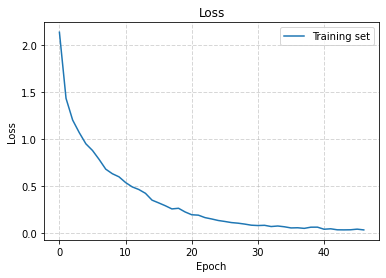

In [ ]:
def render_training_history(training_history):
    loss = training_history.history['loss']

    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(loss, label='Training set')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)
    plt.show()

render_training_history(history)

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
{'loss': [2.131870985031128, 1.4308924674987793, 1.201248288154602, 1.0678575038909912, 0.9493511319160461, 0.8789437413215637, 0.7840765714645386, 0.6808894276618958, 0.6325295567512512, 0.5998457670211792, 0.539244532585144, 0.4930296242237091, 0.46524256467819214, 0.4251250922679901, 0.35250869393348694, 0.32355841994285583, 0.2934289276599884, 0.2595425844192505, 0.2664330303668976, 0.22722439467906952, 0.1976851522922516, 0.1934974491596222, 0.16752953827381134, 0.15323898196220398, 0.13705354928970337, 0.1265655905008316, 0.11483580619096756, 0.10850974917411804, 0.09885457903146744, 0.0871889516711235, 0.08348774164915085, 0.0859108567237854, 0.07291413843631744, 0.07857208698987961, 0.07033099234104156, 0.058127619326114655, 0.0599295012652874, 0.05352208763360977, 0.06589625775814056, 0.06637472659349442, 0.04427340626716614, 0.04897235706448555, 0.038281284272670746, 0.037573542445898056, 0.03847957029938698, 0.04519

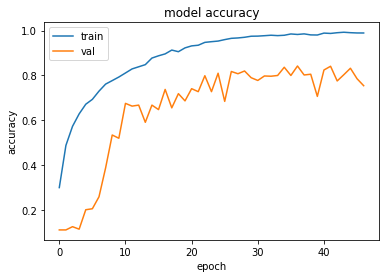

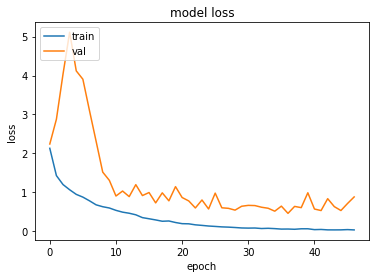

In [ ]:
print(history.history.keys())
print(history.history)
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
model.evaluate(vali_generator)

8/8 [==============================] - 150s 20s/step - loss: 0.6308 - accuracy: 0.8444


[0.6308470368385315, 0.8444444537162781]

8/8 [==============================] - 176s 21s/step - loss: 0.6308 - accuracy: 0.8444
[0.6308470964431763, 0.8444444537162781]

In [ ]:
model.evaluate(train_generator)

64/64 [==============================] - 1733s 27s/step - loss: 0.0404 - accuracy: 0.9909


[0.040374889969825745, 0.9908642172813416]

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

#Confution Matrix and Classification Report
Y_pred = model.predict(vali_generator)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cm = confusion_matrix(vali_generator.classes, y_pred)

print('Classification Report')
print(classification_report(vali_generator.classes, y_pred, target_names=genres))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=genres)

disp.plot(cmap=plt.cm.Blues)
plt.show()

KeyboardInterrupt: ignored

In [ ]:
metrics.confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))